In [1]:
# %% [code] - ADASYN Implementation Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
# %% [code] - Data Preprocessing
# Load original data
original_df = pd.read_excel(r'C:\Project\livertransplant\datasets\GRWR _0.8.xlsx', sheet_name='Sheet1')

# Print EXACT column names with hidden characters
print("Original Columns (Exact Names):")
print([repr(col) for col in original_df.columns])

# Create working copy with renamed column
working_df = original_df.copy(deep=True)

# Define column names
exact_long_col = 'Primary diagnosis:  Ethanol =0; NASH = 1; HBV = 2, HCV = 3, AIH = 4, PSC/Overlap = 5, Wilsons = 6, Hemochromatosis = 7; cryptogenic = 8; BCS = 9; PBC - 10;  Fibrolamellar HCC = 11; Primary hyperoxaluria = 12; Metabolic liver disease = 13, BA = 14, PFIC = 15; HHT = 16; DILI = 17; SBC = 18; yellow phosporous = 19; HEH - 20 ; NCPF = 21; CHF = 22; HEV = 23; HAV = 24; Hepatoblastoma = 25; PCKLD = 26; Alagille = 27, Epidermolysis bullosa = 28; pregnancy related = 29; SLE related = 30; Multiple hepatic adenomas = 31'


# Create working copy with guaranteed rename
working_df = original_df.copy()
working_df.rename(columns={exact_long_col: 'Diagnosis_Code'}, inplace=True)

# Validate rename
assert 'Diagnosis_Code' in working_df.columns, "Rename failed! Check exact_long_col"
print("\nWorking Copy Columns:", working_df.columns.tolist())

# Clean columns in working copy
columns_to_drop = [
    'Tx No', 'Name', 'UHID', 'Adult  = 0; ped = 1 ',
    'Portal vein thrombosis', 'Preoperative HCC',
    'date of surgery', 'additional procedures',
    'Post op Ascites N=0; Y = 1', 'Post op Day 1 bili',
    'post op Day 7 bili', 'INR on day 7', 'Grade3/4 encephalopathy N=0/Y=1',
    'Early graft dysfunction N =0/Y=1', 'HAT', 'PVT',
    'Biliary complications', 'Post op AKI N= 0; Y = 1',
    'Post op sepsis N=0; Y = 1', 'Rexploration N= 0 ; Y = 1',
    'Length of hospital stay', 'Alive/Dead 0 = 0; D=1',
    'in-hospital mortality Y=1, N=0', 'Date of death',
    'Highest clavein dindo score', 'Length of Followup',
    'Other postop complication', 'Cause of death',
    'Additional comments'
 
]
# Ensure no hidden spaces in column names
working_df.columns = working_df.columns.str.strip()

# Drop unwanted columns
working_df = working_df.drop(columns_to_drop, axis=1, errors='ignore')

# Validate if drop worked
print("Remaining Columns after dropping unwanted ones:", working_df.columns.tolist())

# Handle missing values
categorical_cols = working_df.select_dtypes(include=['object']).columns
numerical_cols = working_df.select_dtypes(include=['number']).columns

# Fill categorical columns with mode
for col in categorical_cols:
    working_df[col] = working_df[col].fillna(working_df[col].mode()[0])

# Fill numerical columns with median
for col in numerical_cols:
    working_df[col] = working_df[col].fillna(working_df[col].median())

# Handle missing values
working_df['SFSS Y=1/N=0'] = working_df['SFSS Y=1/N=0'].fillna(0).astype(int)
working_df = working_df.apply(pd.to_numeric, errors='coerce')
working_df = working_df.dropna(axis=1, how='all')
working_df = working_df.fillna(working_df.median())


Original Columns (Exact Names):
["'Tx No'", "'Name'", "'UHID'", "'Age'", "'Gender M = 0; F = 1'", "'Primary diagnosis:  Ethanol =0; NASH = 1; HBV = 2, HCV = 3, AIH = 4, PSC/Overlap = 5, Wilsons = 6, Hemochromatosis = 7; cryptogenic = 8; BCS = 9; PBC - 10;  Fibrolamellar HCC = 11; Primary hyperoxaluria = 12; Metabolic liver disease = 13, BA = 14, PFIC = 15; HHT = 16; DILI = 17; SBC = 18; yellow phosporous = 19; HEH - 20 ; NCPF = 21; CHF = 22; HEV = 23; HAV = 24; Hepatoblastoma = 25; PCKLD = 26; Alagille = 27, Epidermolysis bullosa = 28; pregnancy related = 29; SLE related = 30; Multiple hepatic adenomas = 31'", "'BMI '", "'MELD/PELD'", "'Adult  = 0; ped = 1 '", "'Portal vein thrombosis'", "'Preoperative HCC'", "'date of surgery'", "'Donor Age'", "'Donor Gender M = 0; F=1'", "'Lobe - RL=0, RPS = 1, LL = 2'", "'additional procedures'", "'Graft wt '", "'GRWR'", "'Blood loss'", "'CIT'", "'WIT'", "'Portal velocity'", "'Pre-reperfusion portal pressure'", "'Post- reperfusion portal pressure'",

C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [4]:
target_column = 'SFSS Y=1/N=0'  # Verify exact target column name

# Safety checks
assert target_column in working_df.columns, f"Target column '{target_column}' not found in DataFrame"
assert len(working_df) > 0, "Working DataFrame is empty"

# Create X and y
X = working_df.drop(columns=[target_column])
y = working_df[target_column]

# Verify shapes
print(f"\nData Shape: {X.shape}")
print(f"Target Distribution:\n{y.value_counts()}")



Data Shape: (193, 26)
Target Distribution:
SFSS Y=1/N=0
0    176
1     17
Name: count, dtype: int64


In [5]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,
    random_state=42,
    shuffle=True
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply ADASYN only on training data
adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train_scaled, y_train)

print("\nClass Distribution:")
print(f"Original: {pd.Series(y_train).value_counts()}")
print(f"After ADASYN: {pd.Series(y_res).value_counts()}")



Class Distribution:
Original: SFSS Y=1/N=0
0    140
1     14
Name: count, dtype: int64
After ADASYN: SFSS Y=1/N=0
1    141
0    140
Name: count, dtype: int64


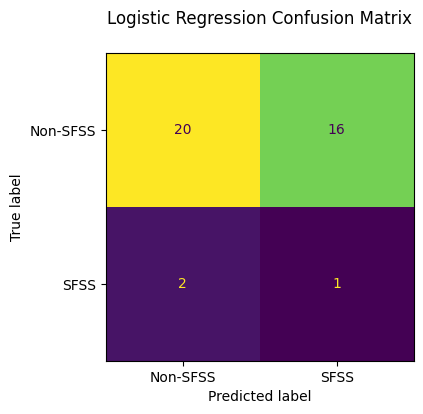

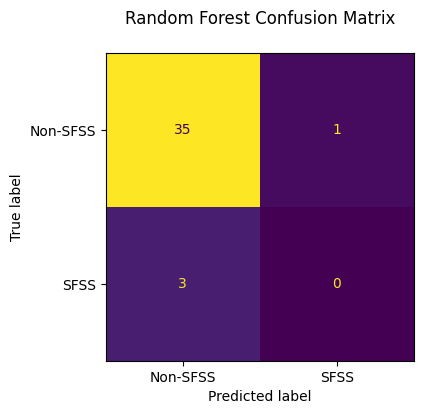

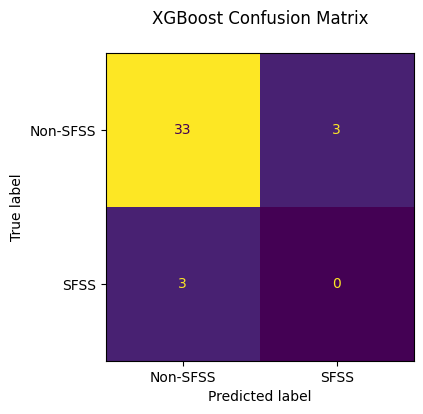

In [6]:
# %% [code] - Model Training with ADASYN
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

results = []
feature_importances = []

for name, model in models:
    # Training
    model.fit(X_res, y_res)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba),
        'AP': average_precision_score(y_test, y_proba)
    }
    results.append(metrics)
    
    # Feature importance
    if hasattr(model, 'feature_importances_'):
        feature_importances.append({
            'model': name,
            'importances': model.feature_importances_
        })
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Non-SFSS', 'SFSS'])
    disp.plot(ax=ax, colorbar=False)
    plt.title(f'{name} Confusion Matrix\n')
    plt.grid(False)
    plt.show()


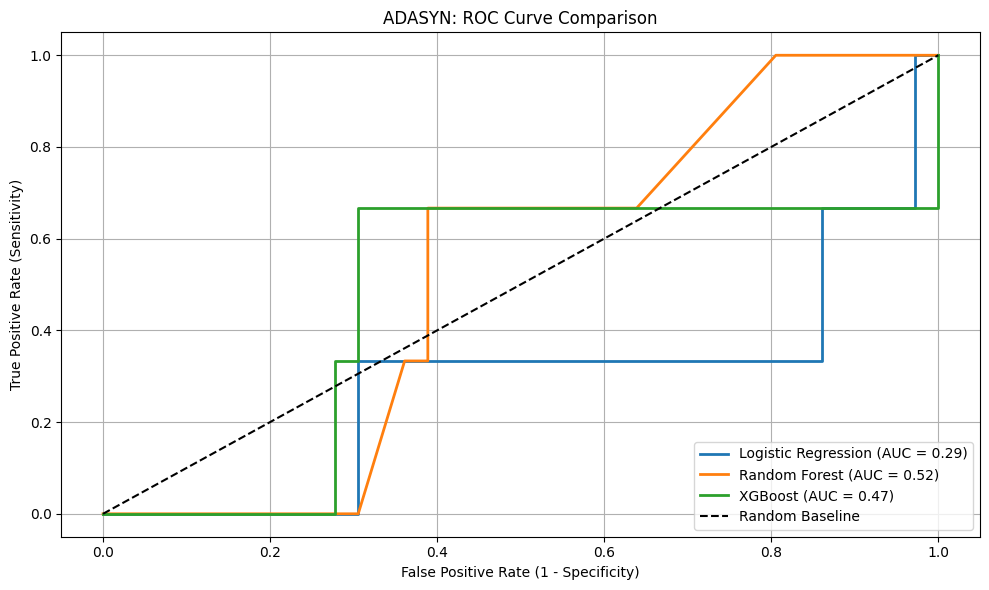

In [7]:
# %% [code] - Performance Visualization
# ROC Curves
plt.figure(figsize=(10, 6))
for name, model in models:
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, lw=2, 
            label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ADASYN: ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

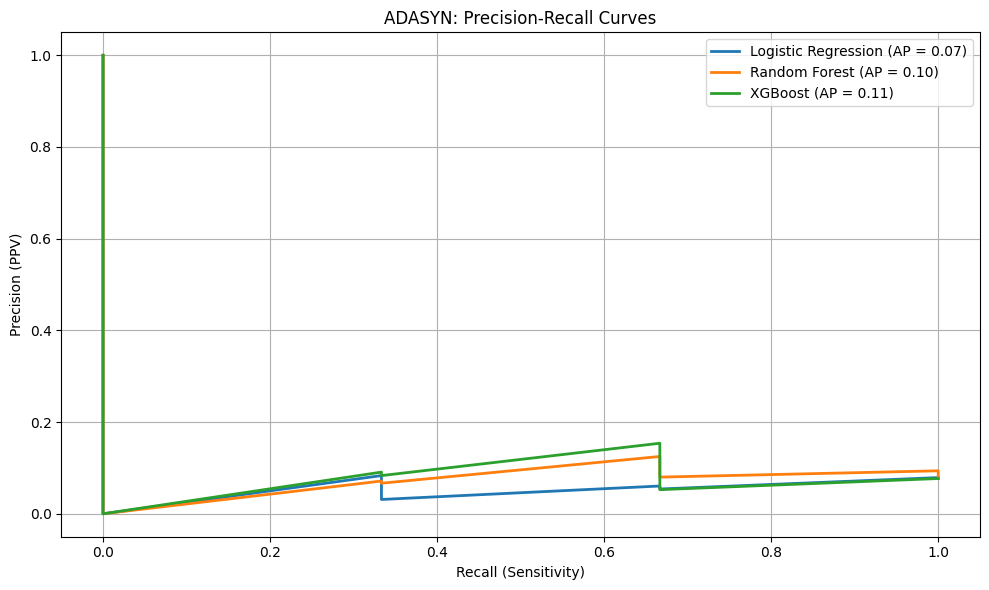

In [8]:

# Precision-Recall Curves
plt.figure(figsize=(10, 6))
for name, model in models:
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, lw=2,
            label=f'{name} (AP = {average_precision_score(y_test, y_proba):.2f})')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('ADASYN: Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# %% [code] - Results Summary
results_df = pd.DataFrame(results).round(3)
print("\nADASYN Augmentation Results:")
display(results_df.style.format({
    'Accuracy': '{:.2f}',
    'Precision': '{:.2f}',
    'Recall': '{:.2f}',
    'F1': '{:.2f}',
    'AUC': '{:.2f}',
    'AP': '{:.2f}'
}).highlight_max(color='lightgreen', subset=['AUC', 'F1', 'Recall']))


ADASYN Augmentation Results:


,Model,Accuracy,Precision,Recall,F1,AUC,AP
0,Logistic Regression,0.54,0.06,0.33,0.10,0.29,0.07
1,Random Forest,0.90,0.00,0.00,0.00,0.52,0.10
2,XGBoost,0.85,0.00,0.00,0.00,0.47,0.11


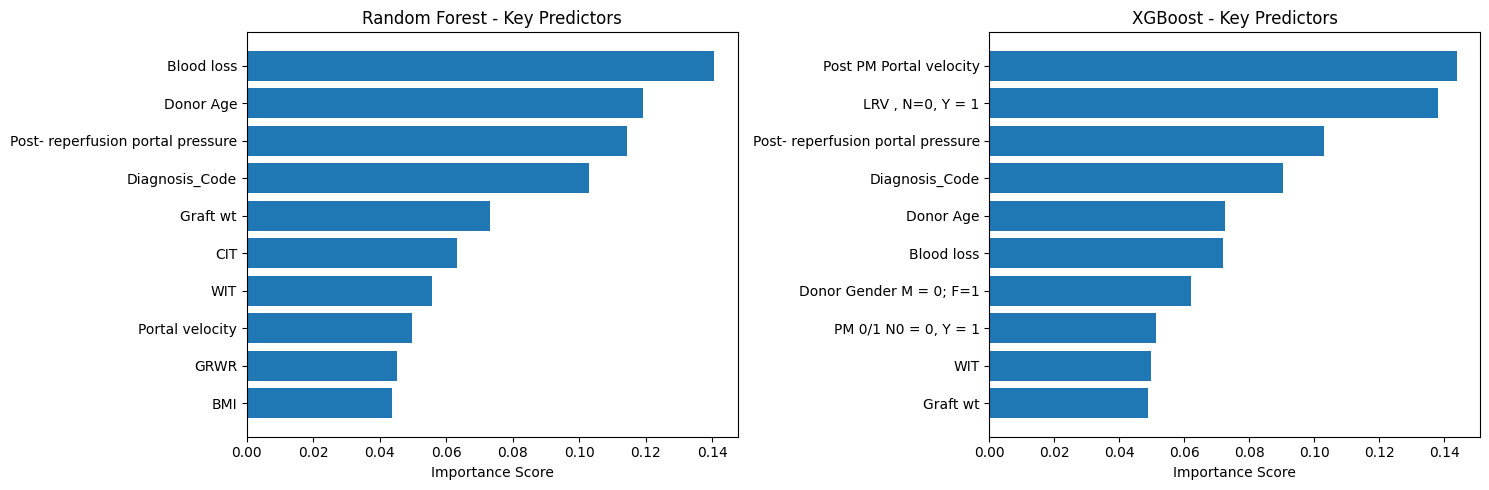

In [10]:
# Feature Importance
if feature_importances:
    plt.figure(figsize=(15, 5))
    for idx, fi in enumerate(feature_importances, 1):
        plt.subplot(1, len(feature_importances), idx)
        importances = fi['importances']
        indices = np.argsort(importances)[-10:]
        
        plt.barh(X.columns[indices], importances[indices])
        plt.title(f"{fi['model']} - Key Predictors")
        plt.xlabel('Importance Score')
    
    plt.tight_layout()
    plt.show()